In [75]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
from examples.ista import sol_2_obj_diff
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval, k_steps_train_ista, create_projection_fn, lin_sys_solve, k_steps_train_fista, k_steps_eval_ista, k_steps_eval_fista
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.ista_model import ISTAmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.ista import generate_b_mat
from scipy.spatial import distance_matrix
from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors
import numpy as np
# from tensorflow.keras.datasets import mnist
# import cv2
import gzip
from scipy import signal
import pywt
import scipy.linalg as la

In [82]:
# def construct_haar(n, level=2):
#     img = np.eye(n)
#     coeffs = pywt.wavedec2(img, 'haar', level=2)
#     H = np.zeros((n, n))
#     half = int(n)

#     # top left block
#     H[:half, :half] = 

#     # other blocks
#     H[:half, half:] = 
#     H[half:, :half] = 
#     H[half:, half:] = 

#     return jnp.array(H)


def haarMatrix(n, normalized=False):
    # Allow only size n of power 2
    n = int(2**np.ceil(np.log2(n)))

    if n == 2:
        H = np.array([[1,1], [1, -1]])
    else:
        Hprev = haarMatrix(n//2)
        Left = np.kron(Hprev, [[1], [1]])
        Right = np.kron(np.eye(n//2), [[1], [-1]])
        H = np.hstack((Left, Right))
    
    if normalized:
        d = np.zeros(n)
        d[0] = 1/np.sqrt(n)
        start = 1
        for r in np.arange(int(np.log2(n))):
            d[start:start+2**r] = np.power(2, -(np.log2(n)-r)/2)
            start = start + 2**r
        H = H @ np.diag(d)
    return H

def vectorized2DHaarMatrix(m, n, d=1):
    # Let H_n be an orthonormal haar matrix of size 2^n. Then the 2d Haar transform of a 2^m by 2^n matrix A is given by
    # H_m^{-1} A (H_n^{-1})^T = H_m^T A H_n
    # This corresponds to mapping vec(A) to M vec(A), where M = (H_n^T \otimes H_m^T)
    # This function returns M^d, corresponding to taking the 2D Haar transformation d times
    
    Hcols = np.linalg.matrix_power(haarMatrix(m, normalized=True).T, d)
    Hrows = np.linalg.matrix_power(haarMatrix(n, normalized=True).T, d)
    
    return np.kron(Hrows, Hcols).T

def blurMatrix(m,width=3):
    # width should be odd
    halflen = int(np.ceil((width-1)/2))
    
    r, c = np.zeros(m), np.zeros(m)
    c[:1+halflen] = 1/width
    r[:1+halflen] = 1/width
    
    return la.toeplitz(c, r)

def vectorized2DBlurMatrix(m, n, width=3):
    # This function returns B corresponding to blurring the columns and rows of an image independently using averaging filters with the same filter width, and
    # represents this process as a matrix operating on the mn vector obtained by vectorizing the image
    Bcols = blurMatrix(m, width) #+ .1 * np.eye(n)
    Brows = blurMatrix(n, width) #+ .1 * np.eye(n)
    U, S, VT = np.linalg.svd(Brows)
    print('S', S)
    
    return np.kron(Brows, Bcols)

In [83]:
import urllib.request
import os

# Create directory to store MNIST dataset
if not os.path.exists('mnist_data'):
    os.makedirs('mnist_data')

# Download training set images and labels
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                           'mnist_data/train-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
                           'mnist_data/train-labels-idx1-ubyte.gz')

# Download test set images and labels
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                           'mnist_data/t10k-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
                           'mnist_data/t10k-labels-idx1-ubyte.gz')

('mnist_data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x2977e0160>)

In [84]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load MNIST dataset
x_train, y_train = load_mnist('mnist_data', kind='train')
x_test, y_test = load_mnist('mnist_data', kind='t10k')

# Normalize pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

[10.28731456  9.32303228  8.60188364  7.85696976  7.65354222  7.42333537
  7.09052082  6.98747859  6.29376485  5.85336961  5.52733467  5.13793692
  4.62413259  4.4177606   4.27252514  3.79997269  3.37794048  3.07025532
  2.50438047  2.30075012  1.86368356  1.559788    1.44739471  1.08503161
  0.75946886  0.70332502  0.38220905  0.15043126]
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(7, 7)
(7, 7)
(7, 7)
Haar (28, 28)
S [9.88736781e-01 9.55393509e-01 9.01289917e-01 8.28561897e-01
 7.40069955e-01 6.39279518e-01 5.30124351e-01 4.16879515e-01
 3.04154718e-01 2.42331533e-01 2.41235699e-01 2.19748864e-01
 2.15380129e-01 2.00000000e-01 1.91041019e-01 1.83360685e-01
 1.74545831e-01 1.73987910e-01 1.41213718e-01 1.34439334e-01
 1.20468939e-01 1.13593964e-01 8.25287808e-02 7.35030102e-02
 6.05095328e-02 5.75521640e-02 9.15032451e-17 5.53332304e-17]
B cond 1.259832874278127e+18
evals B [-9.86947448e-17 -8.82583192e-17 -7.12815593e-17 -5.66587764e-17
 -4.50380012e-17 -4.47895343e-17 -4.01553205e-17 -3.77573285e-1

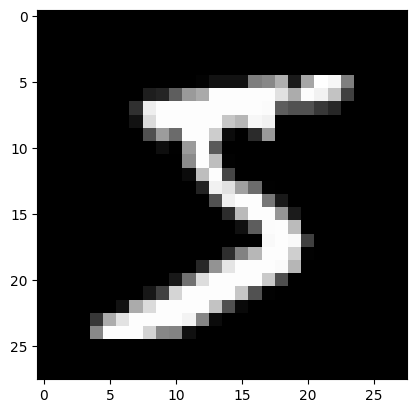

In [85]:
x_train.shape
x_train_img = np.reshape(x_train, (60000, 28, 28))
plt.imshow(x_train_img[0,:,:], cmap='gray')


c = np.zeros(28)
s = 5
c[:s] = (s - np.arange(0,s))/(2*s)
blur_matrix = la.toeplitz(c)
# blur_matrix = blur_matrix / blur_matrix.sum(axis=1)

# plt.imshow(blur_matrix + .01*np.random.normal(size=(28,28)))
# plt.imshow(blur_matrix)
# print('sum', blur_matrix.sum(axis=0))

# # Define blur filter size
# blur_size = 3

# # Define blur filter matrix
# blur_filter = np.ones((blur_size, blur_size)) / (blur_size ** 2)
# blur_filter[1, 1] = 10
# blur_filter = blur_filter / blur_filter.sum()


# # Reshape filter matrix to 1D vector
# blur_filter = blur_filter.reshape(-1)

# # Create blur matrix for MNIST images
# blur_matrix = np.zeros((28, 28))

# for i in range(28):
#     for j in range(28):
#         if abs(i - j) < blur_size ** 2:
#             blur_matrix[i, j] = blur_filter[abs(i - j)]
U, S, VT = jnp.linalg.svd(blur_matrix + 1*np.random.normal(size=(28,28)))
print(S)

blur_matrix_kron = np.kron(blur_matrix, blur_matrix)

# Define the blur matrix r (size 28 x 28)
blur_kernel = np.array([[1,2,1],
                        [2,4,2],
                        [1,2,1]])
R = signal.convolve2d(np.eye(28), blur_kernel, mode='same')

# Perform the three-stage Haar wavelet transform on the image
coeffs = pywt.wavedec2(x_train_img[0, :, :], 'haar', level=3)
# print('coeffs', coeffs)
print(coeffs[0].shape)
print(coeffs[1][0].shape)
print(coeffs[1][1].shape)
print(coeffs[1][2].shape)
print(coeffs[2][0].shape)
print(coeffs[2][1].shape)
print(coeffs[2][2].shape)
Haar = pywt.waverec2(coeffs, 'haar')
print('Haar', Haar.shape)
H = np.kron(Haar, Haar)
# print(coeffs[3][0].shape)

# # Concatenate the low-frequency coefficient matrix with the high-frequency coefficient matrices
# # W = np.concatenate([np.concatenate(coeffs[0]), np.concatenate(coeffs[1][0]), np.concatenate(coeffs[1][1]), np.concatenate(coeffs[1][2])], axis=0)
# W = np.concatenate([
#     np.concatenate(coeffs[0]).reshape(-1, 1),
#     np.concatenate(coeffs[1][0]).reshape(-1, 1),
#     np.concatenate(coeffs[1][1]).reshape(-1, 1),
#     np.concatenate(coeffs[1][2]).reshape(-1, 1),
# ], axis=1)
# print('W', W.shape)
B = vectorized2DBlurMatrix(28, 28, 5) #+ .01 * np.eye(784)
print('B cond', np.linalg.cond(B))
evals, evecs = np.linalg.eigh(B.T @ B)
print('evals B', evals)
# B = blur_matrix_kron
# H = vectorized2DHaarMatrix(28, 28) 
# print('H', H.shape)

# Compute the matrix A = RW
A = np.matmul(B, H)
print('A', A.shape)

ww = H @ x_train[0, :]
print('nnz', np.where(ww == 0)[0].size)
print('nnz', np.where(x_train[0, :] == 0)[0].size)

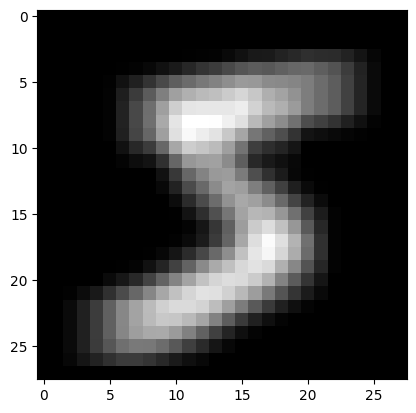

In [86]:
# blurred_vecs = blur_matrix_kron @ x_train[:5,:].T
# blurred_img = np.reshape(blurred_vecs.T[0,:], (28, 28))
blurred_vecs = A @ x_train[:5,:].T

b_vecs = B @ x_train[:5,:].T
blurred_img = np.reshape(b_vecs.T[0,:], (28, 28))
plt.imshow(blurred_img, cmap='gray')
# plt.imshow(np.reshape(H @ x_train[0, :], (28, 28)))

finished solving cvxpy problems
diff to original 3.565228038497272


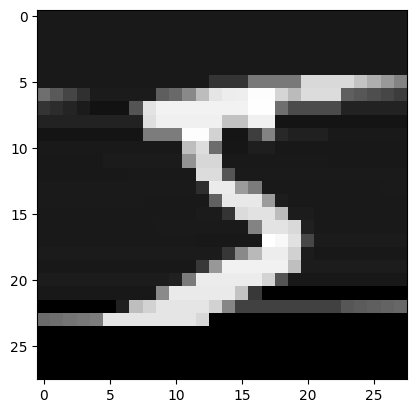

In [93]:
# deblur
lambd = 1e-4
# mask = np.random.binomial(1, .2, size=(10, 784))
# noise = np.multiply(.1*np.random.normal(size=(10, 784)), mask)
# b_mat = x_train[:10, :] + noise
# b_mat = x_train[:10, :]
b_mat = blurred_vecs.T
x_stars, objvals = solve_many_probs_cvxpy(A, b_mat, lambd)
# x_stars, objvals = solve_many_probs_cvxpy(blur_matrix_kron, b_mat, lambd)
# x_stars, objvals = solve_many_probs_cvxpy(np.eye(784), b_mat, lambd)

# blurred_vec = blur_matrix_kron @ x_train[2,:]
recovered_img = np.reshape(x_stars[0, :], (28, 28))
# plt.imshow(np.reshape(b_mat[0,:], (28, 28)))
plt.imshow(recovered_img, cmap='gray')

# print(np.linalg.norm(blur_matrix_kron @ x_stars[0,:] - b_mat[0,:]))
# print(objvals)

print('diff to original', np.linalg.norm(x_stars[0,:] - x_train[0,:]))

# evals, evecs = np.linalg.eigh(blur_matrix_kron.T @ blur_matrix_kron)
evals, evecs = np.linalg.eigh(A.T @ A)

# print('min eval', evals.min())


In [97]:


b = jnp.array(b_mat[0, :])
z0 = jnp.array(np.random.normal(size=(784)))
# A = jnp.array(blur_matrix_kron)
A_jax = jnp.array(A)
evals, evecs = jnp.linalg.eigh(A_jax.T @ A_jax)
step = 1 / evals.max()
print('evals', evals)
k = 2000
z_k, losses, z_all = k_steps_eval_ista(k, z0, b, lambd, A_jax, step, supervised=False, z_star=None, jit=True)


evals [-4.83011682e-14 -1.18782268e-14 -7.42322343e-15 -3.50587040e-15
 -1.15323674e-15 -5.35754651e-16 -4.39108762e-16 -2.15669356e-16
 -9.57588881e-17 -7.25823360e-17 -6.28263718e-17 -4.62903087e-17
 -3.79519585e-17 -2.62161872e-17 -8.05404534e-18 -4.56785737e-18
 -2.71804552e-18 -2.69974713e-18 -1.50941474e-18 -1.35799114e-18
 -1.07074987e-18 -5.62801022e-19 -4.92347146e-19 -1.89282489e-19
 -1.66384858e-19 -1.04249224e-19 -5.66751066e-20 -4.20900532e-20
 -3.41515796e-20 -2.82204666e-20 -2.19452292e-20 -1.79200582e-20
 -1.57841865e-20 -1.48997749e-20 -7.90152524e-21 -3.64112149e-21
 -1.31720175e-21 -9.23902683e-22 -9.03401792e-22 -8.47215688e-22
 -3.12576963e-22 -1.34478645e-22 -1.04030421e-22 -9.03998569e-23
 -5.79520634e-23 -3.45280588e-23 -2.78686814e-23 -1.90433502e-23
 -1.58333168e-23 -3.47861024e-24 -2.23361161e-24 -1.64669749e-24
 -1.20466161e-24 -1.10521902e-24 -3.43694752e-27 -3.08581416e-27
 -1.65793382e-27 -1.97217305e-31 -1.49676255e-31 -6.45871878e-32
 -4.36572883e-32 -9

obj diff 3.129074702673154
z_k [ 0.82709264  2.27161832  0.68429382 -0.17910082 -0.39539861 -0.14761369
  1.00585944 -0.53959633  1.17623464 -0.49188143]
z_star [-0.00164603 -0.00164603 -0.00164603 -0.00164603 -0.00164603 -0.00164603
 -0.00164603 -0.00164603 -0.00164603 -0.00164603]
dist to opt 27.798631184414926
dist to orig 27.910064148141927


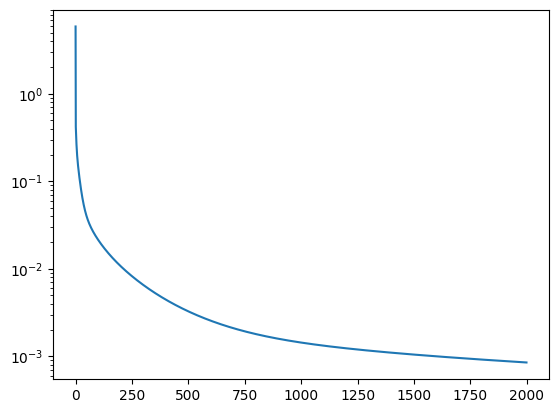

In [98]:
plt.plot(losses)
plt.yscale('log')

# create relative obj fn
partial_rel = partial(sol_2_obj_diff, A=A_jax, lambd=lambd)
# batch_rel = vmap(partial_rel, in_axes=(0, 0, 0), out_axes=(0))
# batch_rel_mat = vmap(batch_rel, in_axes=(1, None, None), out_axes=(0))
# obj_diff = batch_rel_mat(z_all, b_mat[0,:], objvals[0])
obj_diff = partial_rel(z_k, b_mat[0,:], objvals[0])
print('obj diff', obj_diff)
print('z_k', z_k[:10])
print('z_star', x_stars[0,:10])
print('dist to opt', jnp.linalg.norm(z_k -  x_stars[0,:]))
print('dist to orig', jnp.linalg.norm(z_k -  x_train[0,:]))
# plt.imshow(jnp.reshape(z_k, (28, 28)), cmap='gray')

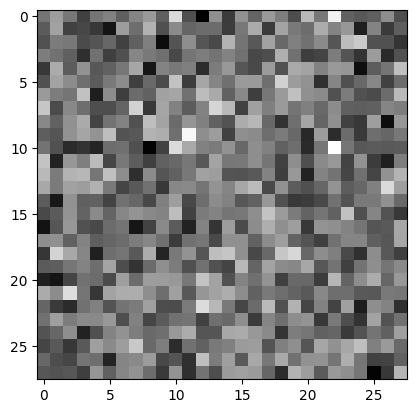

In [96]:
plt.imshow(jnp.reshape(z_k, (28, 28)), cmap='gray')

In [ ]:
 # solve with cvxpy
z_stars, objvals = solve_many_probs_cvxpy(A, b_mat, lambd)
objvals_train = objvals[:N_train]
objvals_test = objvals[N_train:]
z_stars_train = z_stars[:N_train, :]
z_stars_test = z_stars[N_train:, :]

# create relative obj fn
partial_rel = partial(sol_2_obj_diff, A=A, lambd=lambd)
batch_rel = vmap(partial_rel, in_axes=(0, 0, 0), out_axes=(0))
batch_rel_mat = vmap(batch_rel, in_axes=(1, None, None), out_axes=(0))

finished solving cvxpy problems


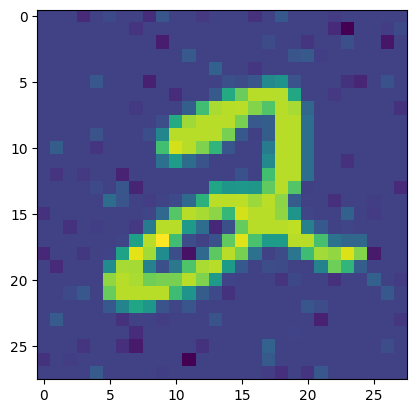

In [191]:
plt.imshow(recovered_img)

In [7]:
# create l2ws_model
# nn_cfg = {'lr': 1e-5} 
nn_cfg = {}
# nn_cfg = {'intermediate_layer_sizes': [200]} #, 'lr': 1e-1}
train_unrolls = 50
input_dict = dict(algorithm='ista',
                    supervised=False,
                    train_unrolls=train_unrolls, 
                    jit=True,
                    train_inputs=train_inputs, 
                    test_inputs=test_inputs,
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    lambd=lambd,
                    ista_step=ista_step,
                    A=A,
                    nn_cfg=nn_cfg,
                    z_stars_train=z_stars_train,
                    z_stars_test=z_stars_test,
                    )
l2ws_model = ISTAmodel(input_dict)

In [8]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = l2ws_model.evaluate(k, nearest_neighbors_z, b_mat_test, z_stars=z_stars_test, fixed_ws=True, tag='test')
nn_z_all = nn_eval_out[1][3]
nn_rel_objs = batch_rel_mat(nn_z_all, b_mat_test, objvals_test).mean(axis=1)
nn_losses = nn_eval_out[1][1].mean(axis=0)

# evaluate test before training
init_test_loss, init_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
init_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)
init_z_all = init_eval_out[1][3]
init_rel_objs = batch_rel_mat(init_z_all, b_mat_test, objvals_test).mean(axis=1)

distances [[11.28595094 10.19955971 12.08221381 ... 10.73967427 10.40359024
  11.02370339]
 [11.154609   11.10055938 11.38638715 ...  9.59148402 11.0870724
  11.49522852]
 [10.76148637 10.10169411 10.0070559  ... 10.02443974 11.86219263
  10.03742729]
 ...
 [ 8.22071553  9.78708547 10.98012113 ...  9.80395687  9.44522792
  10.46375583]
 [ 9.69722139 10.7477999  11.77437525 ...  9.29833084 10.07201084
  11.01006088]
 [ 9.70197362 10.62003826 11.64602543 ... 10.1199711  10.73180157
   9.15643014]]
indices [ 8 72  5 83 45 83 42 45 42 33 10 39 39 51 27 47  8 70 89 61]
best val [8.24069148 8.49276924 8.76464832 8.00707777 8.39094557 8.48057409
 8.13411354 7.54711438 7.87090907 7.76695723 8.72316557 7.33980079
 8.26248121 7.59932524 8.26009263 8.53822742 7.89090573 7.2178491
 8.35122036 7.58625515]


In [9]:
# call train_batch without jitting
params, state = l2ws_model.params, l2ws_model.state
num_epochs = 1000
losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = l2ws_model.train_full_batch(params, state)
    loss, params, state = train_result
    losses = losses.at[i].set(loss)

l2ws_model.params, l2ws_model.state = params, state

In [10]:
# evaluate test after training
final_test_loss, final_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
final_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_z_all = final_eval_out[1][3]
final_rel_objs = batch_rel_mat(final_z_all, b_mat_test, objvals_test).mean(axis=1)

final_test_losses = final_eval_out[1][1].mean(axis=0)

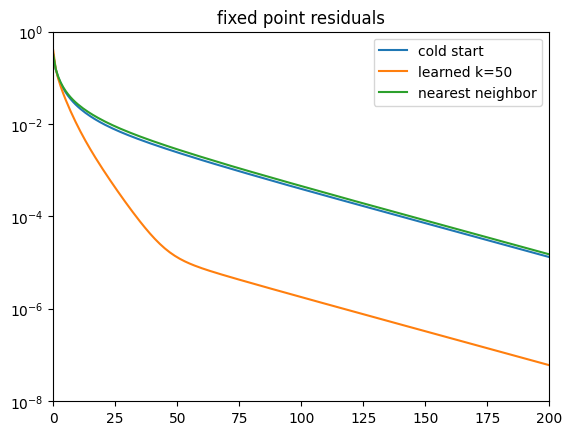

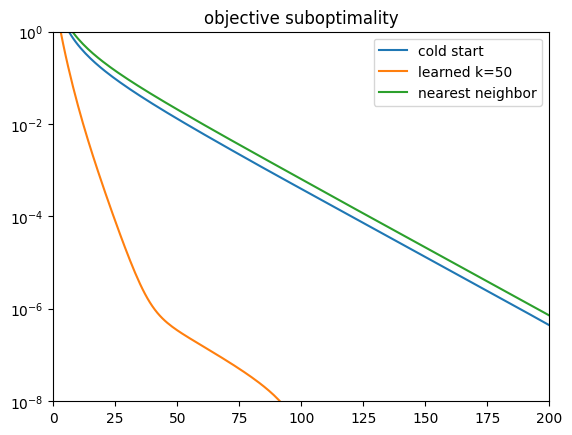

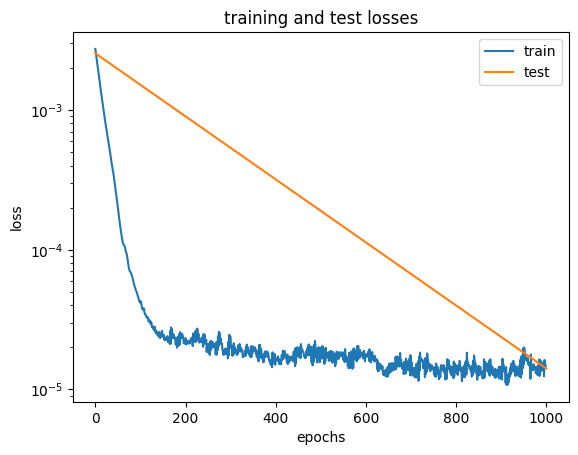

In [16]:
plt.plot(init_test_losses, label='cold start')
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(nn_losses, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.xlim((0,200))
plt.ylim((1e-8,1))
plt.title('fixed point residuals')
plt.legend()
plt.show()

plt.plot(init_rel_objs, label='cold start')
plt.plot(final_rel_objs, label=f"learned k={train_unrolls}")
plt.plot(nn_rel_objs, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.xlim((0,200))
plt.ylim((1e-8,1))
plt.title('objective suboptimality')
plt.legend()
plt.show()

plt.plot(losses, label='train')
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training and test losses')
plt.legend()
plt.show()

In [ ]:
# get accuracies for certain metrics